Source: https://www.kaggle.com/datasets/mvianna10/germany-electricity-power-for-20062017

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sklearn.metrics
import optuna

color_pal = sns.color_palette()

/home/erica/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_raw = pd.read_csv('./data_raw/opsd_germany_daily.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         4383 non-null   object 
 1   Consumption  4383 non-null   float64
 2   Wind         2920 non-null   float64
 3   Solar        2188 non-null   float64
 4   Wind+Solar   2187 non-null   float64
dtypes: float64(4), object(1)
memory usage: 171.3+ KB


In [3]:
df = df_raw.drop(columns=['Wind', 'Solar', 'Wind+Solar'])
df['Date'] = pd.to_datetime(df.Date)

df = df.set_index('Date')

<AxesSubplot: title={'center': 'Germany Energin'}, xlabel='Date'>

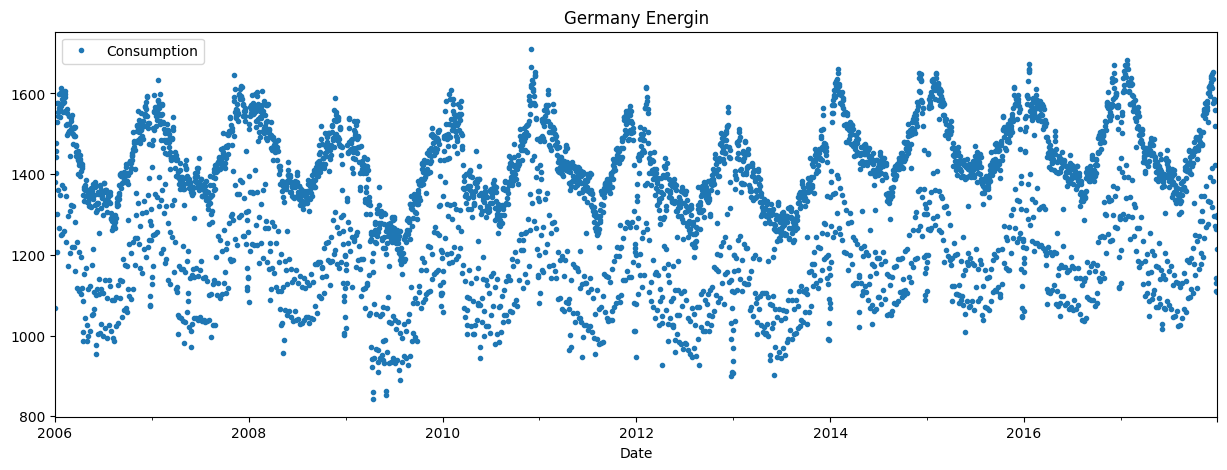

In [4]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='Germany Energin')

# Train/ Test Split

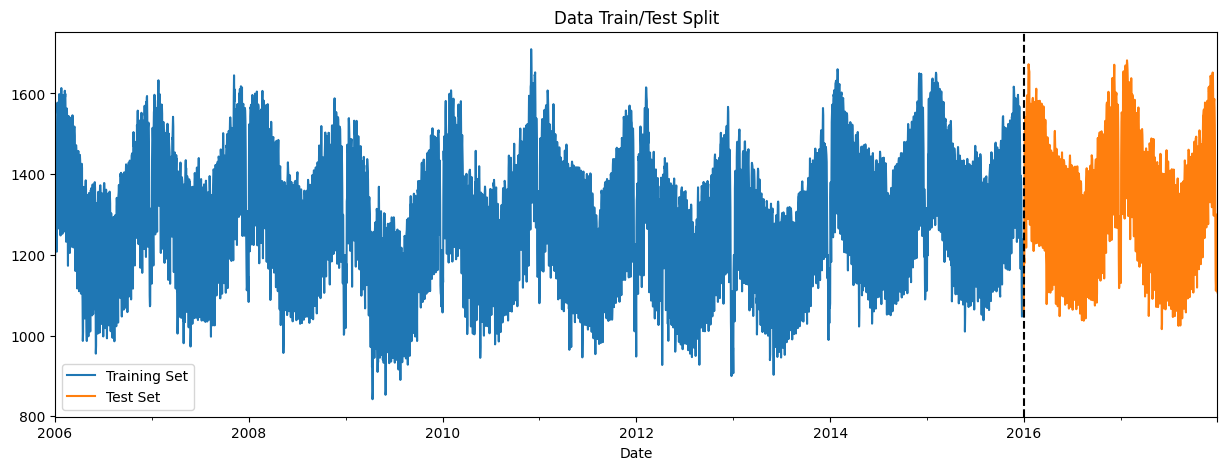

In [5]:
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, title = 'Data Train/Test Split')
test.plot(ax=ax)
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [6]:
def create_features(df):
    """
    Create time series feature based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['lag'] = df.Consumption.shift(1)
    return df

In [7]:
df = create_features(df)
df.head()

,Consumption,hour,dayofweek,quarter,month,year,dayofyear,is_month_start,is_month_end,lag
Date,,,,,,,,,,
2006-01-01,1069.184,0,6,1,1,2006,1,1,0,NaN
2006-01-02,1380.521,0,0,1,1,2006,2,0,0,1069.184
2006-01-03,1442.533,0,1,1,1,2006,3,0,0,1380.521
2006-01-04,1457.217,0,2,1,1,2006,4,0,0,1442.533
2006-01-05,1477.131,0,3,1,1,2006,5,0,0,1457.217


In [8]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','is_month_start', 'is_month_end', 'lag']
TARGET = 'Consumption'

In [9]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [14]:
lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name= FEATURES)
lgbval = lgb.Dataset(data=X_test, label=y_test, reference=lgbtrain, feature_name= FEATURES)

In [56]:
# https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_integration.py

def objective(trial):
    lgb_params = {
        # "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        #"boosting_type": "gbdt",
        #"lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 10, 75),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),
        "max_depth": trial.suggest_int("max_depth", 15,45)
        # "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        # "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        # "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Add a callback for pruning.
    #pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
    gbm = lgb.train(lgb_params, lgbtrain, valid_sets=[lgbtrain, lgbval], 
                    num_boost_round=10000,
                    early_stopping_rounds=200,
                    verbose_eval=100) 
                    #callbacks=[pruning_callback])
    preds = gbm.predict(X_test)
    # pred_labels = np.rint(preds)
    # print(y_test, pred_labels)
    accuracy = sklearn.metrics.mean_squared_error(y_test, preds)
    return accuracy

In [58]:
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize"
)
study.optimize(objective, n_trials=10)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-10-01 21:01:44,238] A new study created in memory with name: no-name-7cb861c2-e707-4df5-9ea3-fb2cf74f8907
/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 200 rounds
[100]	training's auc: 1	valid_1's auc: 1


[I 2022-10-01 21:01:45,163] Trial 0 finished with value: 28712.929024611243 and parameters: {'num_leaves': 51, 'learning_rate': 0.005773867471470715, 'max_depth': 23}. Best is trial 0 with value: 28712.929024611243.


[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Training until validation scores don't improve for 200 rounds


/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's auc: 1	valid_1's auc: 1


[I 2022-10-01 21:01:45,861] Trial 1 finished with value: 28765.20885520508 and parameters: {'num_leaves': 59, 'learning_rate': 0.004740514954765896, 'max_depth': 39}. Best is trial 0 with value: 28712.929024611243.


[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Training until validation scores don't improve for 200 rounds


/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's auc: 1	valid_1's auc: 1


[I 2022-10-01 21:01:46,391] Trial 2 finished with value: 28805.11829274214 and parameters: {'num_leaves': 38, 'learning_rate': 0.004045181806505526, 'max_depth': 34}. Best is trial 0 with value: 28712.929024611243.


[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Training until validation scores don't improve for 200 rounds


/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-10-01 21:01:46,804] Trial 3 finished with value: 28542.026300651396 and parameters: {'num_leaves': 17, 'learning_rate': 0.009435450491726935, 'max_depth': 40}. Best is trial 3 with value: 28542.026300651396.


[100]	training's auc: 1	valid_1's auc: 1
[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1


/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 200 rounds
[100]	training's auc: 1	valid_1's auc: 1


[I 2022-10-01 21:01:47,521] Trial 4 finished with value: 28906.362122011826 and parameters: {'num_leaves': 65, 'learning_rate': 0.002086491154998223, 'max_depth': 27}. Best is trial 3 with value: 28542.026300651396.


[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Training until validation scores don't improve for 200 rounds


/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's auc: 1	valid_1's auc: 1


[I 2022-10-01 21:01:48,131] Trial 5 finished with value: 28745.473635680097 and parameters: {'num_leaves': 41, 'learning_rate': 0.0051848861417334285, 'max_depth': 40}. Best is trial 3 with value: 28542.026300651396.


[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Training until validation scores don't improve for 200 rounds


/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's auc: 1	valid_1's auc: 1


[I 2022-10-01 21:01:48,729] Trial 6 finished with value: 28953.957298207642 and parameters: {'num_leaves': 40, 'learning_rate': 0.0012126074840523359, 'max_depth': 29}. Best is trial 3 with value: 28542.026300651396.


[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Training until validation scores don't improve for 200 rounds


/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's auc: 1	valid_1's auc: 1


[I 2022-10-01 21:01:49,349] Trial 7 finished with value: 28754.54248616669 and parameters: {'num_leaves': 44, 'learning_rate': 0.004997338240595696, 'max_depth': 37}. Best is trial 3 with value: 28542.026300651396.


[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Training until validation scores don't improve for 200 rounds


/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-10-01 21:01:49,814] Trial 8 finished with value: 28615.21933340642 and parameters: {'num_leaves': 34, 'learning_rate': 0.0076758181758583765, 'max_depth': 26}. Best is trial 3 with value: 28542.026300651396.


[100]	training's auc: 1	valid_1's auc: 1
[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Training until validation scores don't improve for 200 rounds


/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's auc: 1	valid_1's auc: 1


[I 2022-10-01 21:01:50,541] Trial 9 finished with value: 28546.393371958435 and parameters: {'num_leaves': 68, 'learning_rate': 0.008855692761347476, 'max_depth': 20}. Best is trial 3 with value: 28542.026300651396.


[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Number of finished trials: 10
Best trial:
  Value: 28542.026300651396
  Params: 
    num_leaves: 17
    learning_rate: 0.009435450491726935
    max_depth: 40


In [59]:
lgb_params = {'num_leaves': 17,
              'learning_rate':0.009435450491726935,
              'feature_fraction': 0.8,
              'max_depth': 40,
              'verbose': 0,
              'num_boost_round': 7000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [60]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  verbose_eval=100)

/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/erica/.local/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030478 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 8004.42	valid_1's l2: 8327.21
[200]	training's l2: 3469.07	valid_1's l2: 3743.61
[300]	training's l2: 2298.51	valid_1's l2: 2582.98
[400]	training's l2: 1901.67	valid_1's l2: 2222.76
[500]	training's l2: 1715.55	valid_1's l2: 2041.15
[600]	training's l2: 1612.62	valid_1's l2: 1953.2
[700]	training's l2: 1534.41	valid_1's l2: 1893.88
[800]	training's l2: 1477.57	valid_1's l2: 1863.02
[900]	training's l2: 1424.58	valid_1's l2: 1830.09
[1000]	training's l2: 1376.38	valid_1's l2: 1801.43
[1100]	training's l2: 1330.07	valid_1's l2: 1777.39
[1200]	training's l2: 1291.11	valid_1's l2: 1758.38
[1300]	training's l2: 1255.59	valid_1's l2: 1730.64
[1400]	training's l2: 1221.4	valid_1's l2: 1703.87
[1500]	training's l2: 1190.27	valid_1's l2: 1688.41
[160

In [61]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

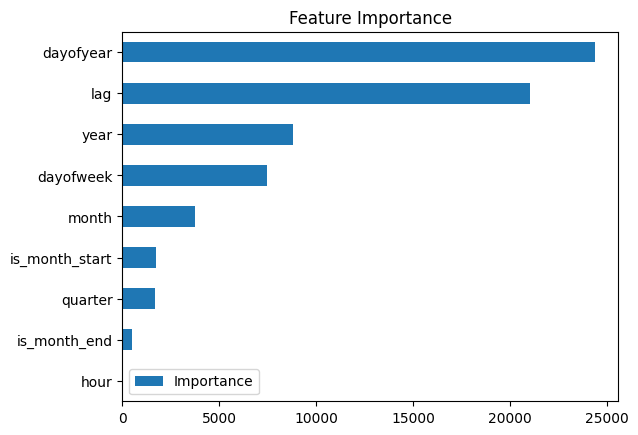

In [62]:
fi = pd.DataFrame(data = model.feature_importance(),
             index=model.feature_name(),
             columns=['Importance'])

fi.sort_values('Importance').plot(kind ='barh', title='Feature Importance')
plt.show()

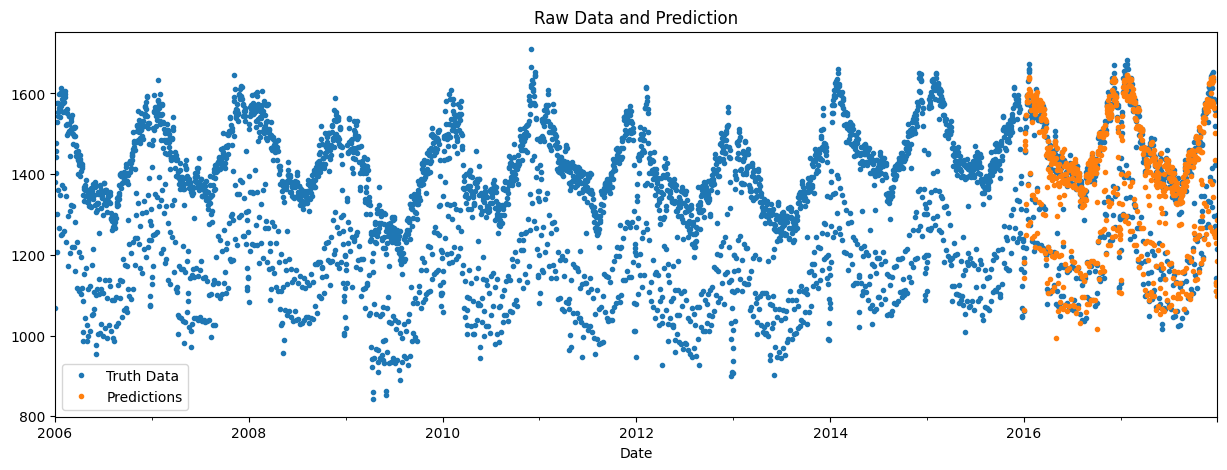

In [63]:
test['prediction'] = model.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Consumption']].plot(figsize=(15,5), style='.')
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [64]:
score = np.sqrt(mean_squared_error(test['Consumption'], test['prediction']))
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 39.57


In [65]:
test['error'] = np.abs(test[TARGET] - test['prediction'])/test[TARGET]

In [66]:
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(10)

date
2016-05-05    0.269482
2017-05-25    0.229659
2016-03-28    0.228251
2016-05-16    0.226987
2017-04-17    0.217599
2016-03-25    0.205715
2016-10-03    0.204856
2017-06-05    0.191968
2017-04-14    0.190477
2017-10-31    0.150284
Name: error, dtype: float64

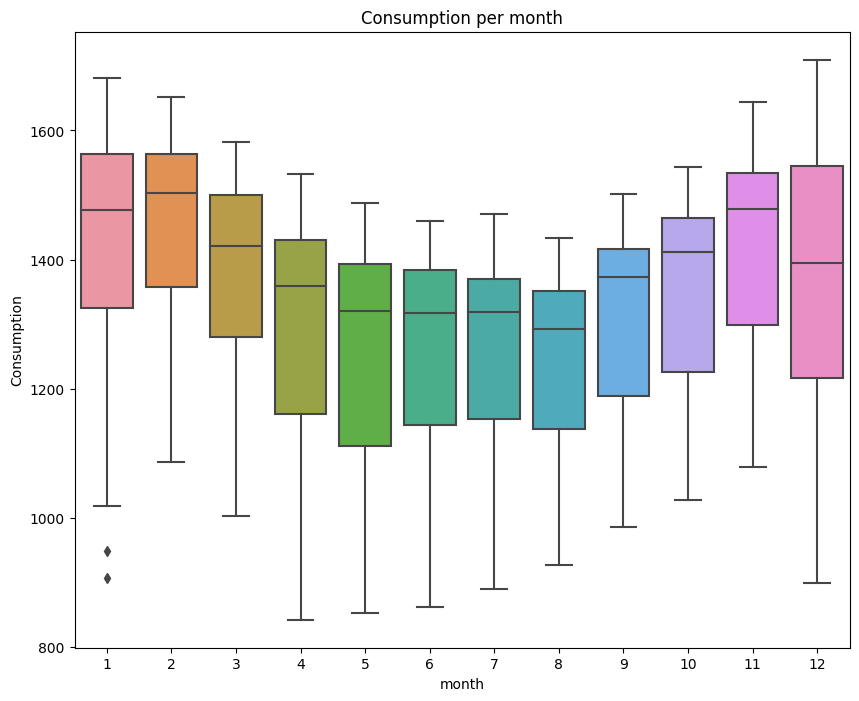

In [67]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='Consumption')
ax.set_title('Consumption per month')
plt.show()

In [68]:
df[['Consumption', 'month']].groupby('month').mean()

,Consumption
month,
1,1433.781435
2,1452.463841
3,1380.694497
4,1298.457644
5,1261.905065
6,1263.169508
7,1266.701788
8,1249.991327
9,1314.348716


In [69]:
df[['Consumption', 'month']].groupby('month').std()


,Consumption
month,
1,161.744962
2,140.682177
3,146.327248
4,158.609557
5,157.969471
6,146.373286
7,139.041736
8,130.969571
9,136.621594


In [70]:
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=True).head(10)

date
2016-02-24    0.000033
2017-08-27    0.000077
2017-12-15    0.000087
2016-04-14    0.000103
2017-12-06    0.000128
2017-10-10    0.000156
2017-08-02    0.000160
2017-05-13    0.000167
2017-03-12    0.000244
2017-02-24    0.000254
Name: error, dtype: float64